In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [3]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [4]:
# prepare function
dataset_path = "/kaggle/working/train"
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img,(420, 540, 1))
    
    return img

In [5]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

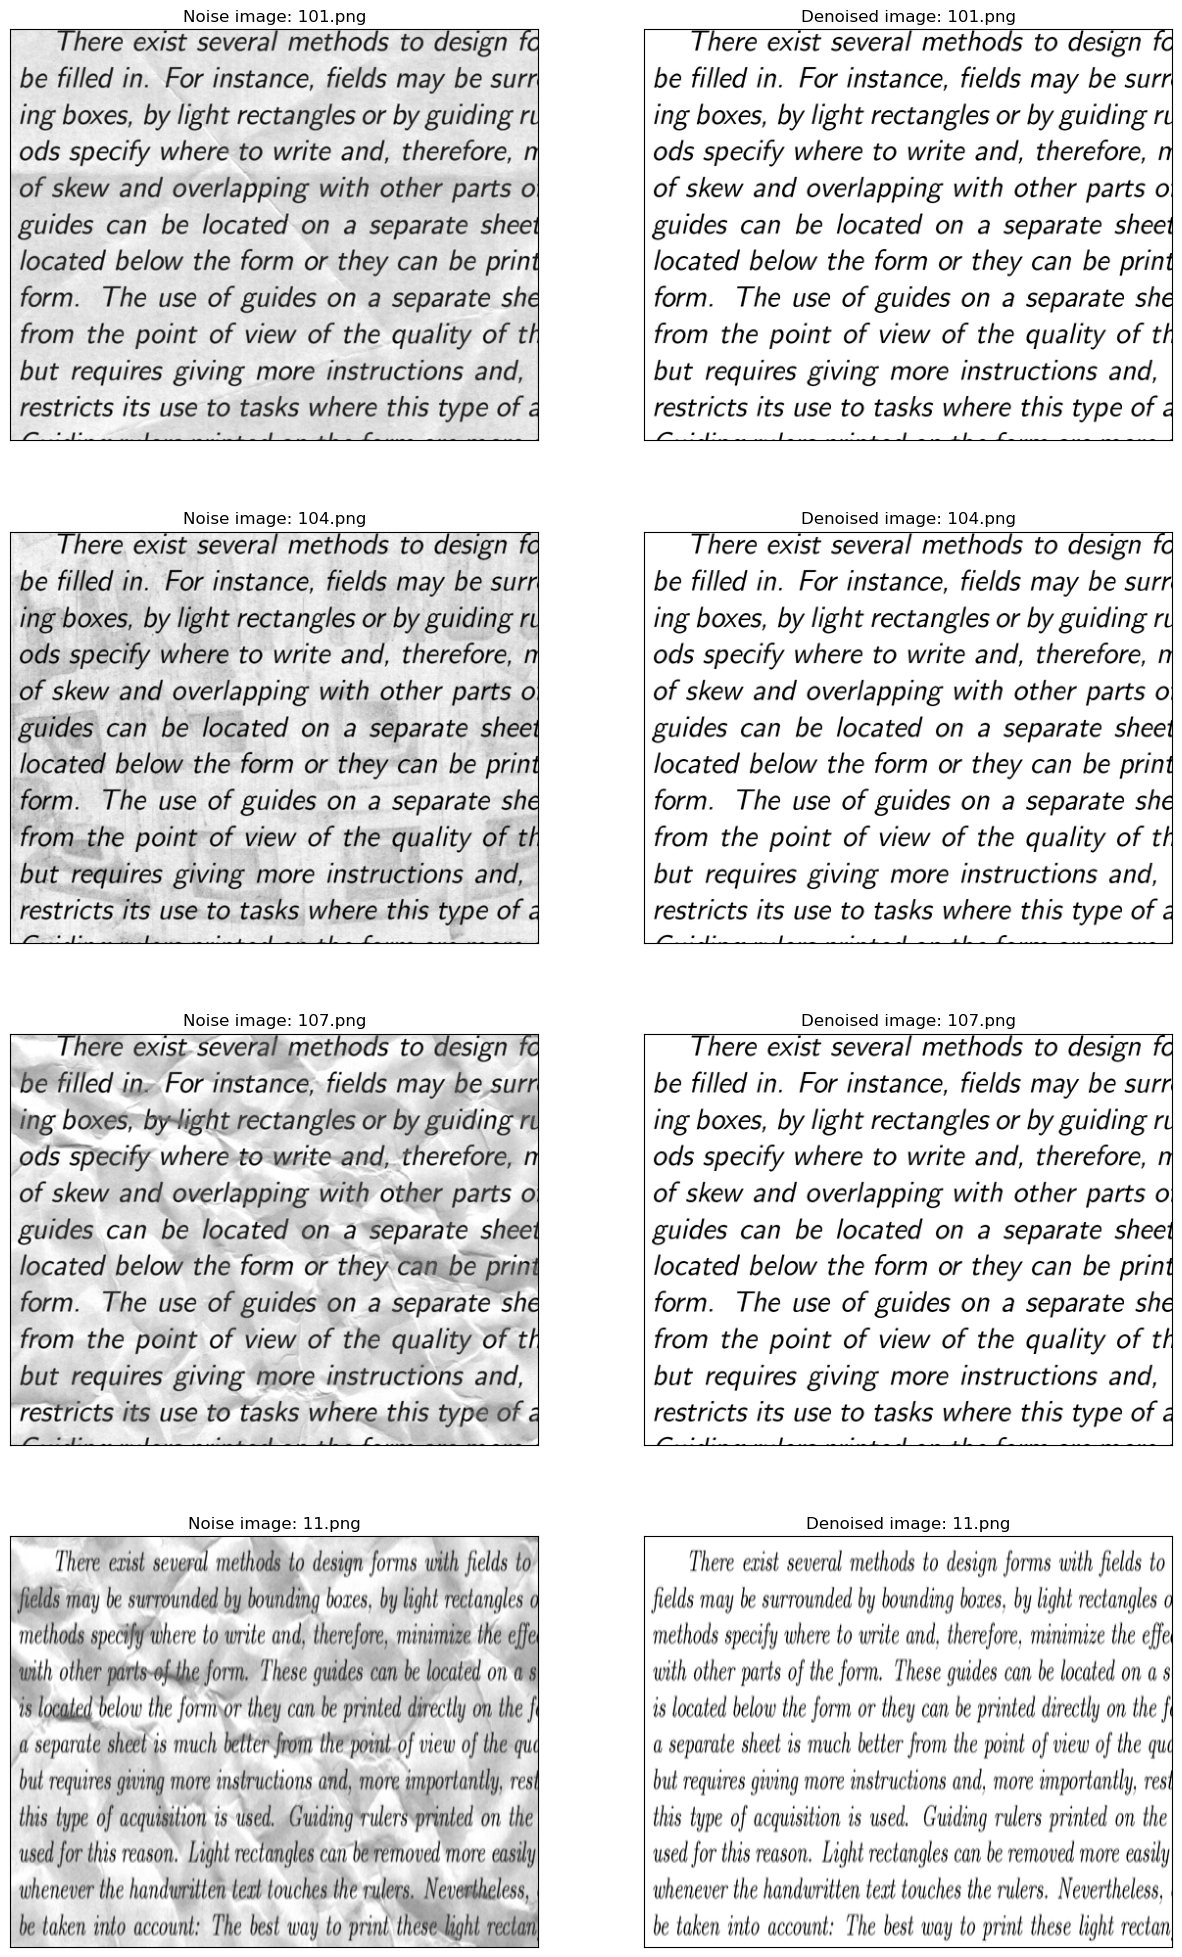

In [6]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [7]:
# convert list to numpy array
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [14]:
# import tensorflow as tf

# def dncnn_model(depth=7, n_channels=16, use_bnorm=True, kernel_size=3, input_shape=(420, 540, 1), image_channels=1):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv2D(n_channels, kernel_size, padding='same', input_shape=input_shape, use_bias=True))
#     model.add(tf.keras.layers.ReLU())

#     for _ in range(depth - 2):
#         model.add(tf.keras.layers.Conv2D(n_channels, kernel_size, padding='same', use_bias=False))
#         if use_bnorm:
#             model.add(tf.keras.layers.BatchNormalization(epsilon=1e-4, momentum=0.95))
#         model.add(tf.keras.layers.ReLU())

#     model.add(tf.keras.layers.Conv2D(image_channels, kernel_size, padding='same', use_bias=False))

#     return model

# input_shape = (420, 540, 1)
# DNCNN = dncnn_model(input_shape=input_shape)


In [8]:
import tensorflow as tf
def dncnn_model(depth=11, n_channels=32, use_bnorm=True, kernel_size=3, input_shape=(420, 540, 1), image_channels=1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(n_channels, kernel_size, padding='same', input_shape=input_shape, use_bias=True))
    model.add(tf.keras.layers.ReLU())

    for _ in range(depth - 2):
        model.add(tf.keras.layers.Conv2D(n_channels, kernel_size, padding='same', use_bias=False))
        if use_bnorm:
            model.add(tf.keras.layers.BatchNormalization(epsilon=1e-4, momentum=0.95))
        model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(image_channels, kernel_size, padding='same', use_bias=False))

    return model


# def contrast_loss(y_true, y_pred):
#     return tf.reduce_mean(tf.square(y_true - y_pred))

input_shape = (420, 540, 1)
DNCNN = dncnn_model(input_shape=input_shape)



In [9]:
DNCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 re_lu (ReLU)                (None, 420, 540, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 32)      9216      
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 420, 540, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 32)      9216      
                                                        

In [ ]:
# history=DNCNN.fit(x=train_shabby,y=train_cleaned,batch_size=16,epochs=50, validation_data=(validate_shabby, validate_cleaned))

In [10]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [11]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
import wandb
from tensorflow.keras.callbacks import EarlyStopping
from wandb.keras import WandbCallback

# Initialize WandB
wandb.init(project='task1-DNCNN', name='Image_Pre')

# Compile the model
DNCNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Define the early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = DNCNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[early_stop, WandbCallback()])

# Save the model architecture as JSON
model_json = DNCNN.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Log the model architecture
wandb.save("model_architecture.json")

# Log the model summary
DNCNN.summary(print_fn=lambda x: wandb.log({"model_summary": x}))

# Finish the run
wandb.run.finish()


wandb: Currently logged in as: yassine-elaadraoui-morosoft (document-preprocessing). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/500
8/8 [==============================] - ETA: 0s - loss: 0.7364 - mse: 0.7364

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 34s 2s/step - loss: 0.7364 - mse: 0.7364 - val_loss: 0.4318 - val_mse: 0.4318
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 0.0964 - mse: 0.0964

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0964 - mse: 0.0964 - val_loss: 0.2298 - val_mse: 0.2298
Epoch 3/500
8/8 [==============================] - ETA: 0s - loss: 0.0564 - mse: 0.0564

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 12s 2s/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 4/500
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0331

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0814 - val_mse: 0.0814
Epoch 5/500
8/8 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0242

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 6/500
8/8 [==============================] - ETA: 0s - loss: 0.0194 - mse: 0.0194

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 7/500
8/8 [==============================] - 9s 1s/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0809 - val_mse: 0.0809
Epoch 8/500
8/8 [==============================] - 9s 1s/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 9/500
8/8 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0126

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 10/500
8/8 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0115

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 11/500
8/8 [==============================] - ETA: 0s - loss: 0.0107 - mse: 0.0107

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 12/500
8/8 [==============================] - ETA: 0s - loss: 0.0099 - mse: 0.0099

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 13/500
8/8 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0094

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 14/500
8/8 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0088

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 15/500
8/8 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0083

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 16/500
8/8 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0079

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 17/500
8/8 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0075

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 18/500
8/8 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0072

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 19/500
8/8 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0069

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 20/500
8/8 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0065

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 21/500
8/8 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0062

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 22/500
8/8 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0061

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 23/500
8/8 [==============================] - ETA: 0s - loss: 0.0059 - mse: 0.0059

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 24/500
8/8 [==============================] - ETA: 0s - loss: 0.0056 - mse: 0.0056

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 25/500
8/8 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 26/500
8/8 [==============================] - ETA: 0s - loss: 0.0053 - mse: 0.0053

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 27/500
8/8 [==============================] - 9s 1s/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 28/500
8/8 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 29/500
8/8 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 30/500
8/8 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 31/500
8/8 [==============================] - 9s 1s/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 32/500
8/8 [==============================] - 9s 1s/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 33/500
8/8 [==============================] - 9s 1s/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 34/500
8/8 [==============================] - 9s 1s/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 35/500
8/8 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 36/500
8/8 [==============================] - 8s 1s/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 37/500
8/8 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 38/500
8/8 [==============================] - 9s 1s/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 39/500
8/8 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 40/500
8/8 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 41/500
8/8 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 42/500
8/8 [==============================] - 9s 1s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 43/500
8/8 [==============================] - 9s 1s/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 44/500
8/8 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 45/500
8/8 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 46/500
8/8 [==============================] - 9s 1s/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 47/500
8/8 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 48/500
8/8 [==============================] - 9s 1s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 49/500
8/8 [==============================] - 9s 1s/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 50/500
8/8 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 51/500
8/8 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 52/500
8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 53/500
8/8 [==============================] - 9s 1s/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 54/500
8/8 [==============================] - 9s 1s/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 55/500
8/8 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 56/500
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 57/500
8/8 [==============================] - 9s 1s/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 58/500
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 59/500
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 60/500
8/8 [==============================] - 9s 1s/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 61/500
8/8 [==============================] - 9s 1s/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 62/500
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 63/500
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 64/500
8/8 [==============================] - 9s 1s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 65/500
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 66/500
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 67/500
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 68/500
8/8 [==============================] - 9s 1s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 69/500
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 70/500
8/8 [==============================] - 9s 1s/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 71/500
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 72/500
8/8 [==============================] - 9s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 73/500
8/8 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 74/500
8/8 [==============================] - 9s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 75/500
8/8 [==============================] - 9s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 76/500
8/8 [==============================] - 9s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 77/500
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 78/500
8/8 [==============================] - 9s 1s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 79/500
8/8 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 80/500
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 81/500
8/8 [==============================] - 9s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 82/500
8/8 [==============================] - 9s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 83/500
8/8 [==============================] - 9s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 84/500
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 85/500
8/8 [==============================] - 9s 1s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 86/500
8/8 [==============================] - 8s 1s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 87/500
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 88/500
8/8 [==============================] - 8s 1s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 89/500
8/8 [==============================] - 8s 1s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 90/500
8/8 [==============================] - 9s 1s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 91/500
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 92/500
8/8 [==============================] - 9s 1s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 93/500
8/8 [==============================] - 9s 1s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 94/500
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 95/500
8/8 [==============================] - 9s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 96/500
8/8 [==============================] - 9s 1s/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 97/500
8/8 [==============================] - 9s 1s/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 98/500
8/8 [==============================] - 9s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 99/500
8/8 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 100/500
8/8 [==============================] - 8s 1s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 101/500
8/8 [==============================] - 9s 1s/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 102/500
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 103/500
8/8 [==============================] - 9s 1s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 104/500
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 105/500
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 106/500
8/8 [==============================] - 9s 1s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 107/500
8/8 [==============================] - 9s 1s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 108/500
8/8 [==============================] - 9s 1s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 109/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 110/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 111/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 112/500
8/8 [==============================] - 9s 1s/step - loss: 0.0018 - mse: 0.0018 - val_loss

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 114/500
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 115/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 116/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 117/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 118/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 119/500
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 120/500
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 121/500
8/8 [==============================] - 8s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 122/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 123/500
8/8 [==============================] - 9s 1s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 124/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 125/500
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 126/500
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 13s 2s/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 127/500
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230731_100741-y56ttrvz/files/model-best)... Done. 0.0s


8/8 [==============================] - 14s 2s/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 128/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 129/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 130/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 131/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 132/500
8/8 [==============================] - 9s 1s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 133/500
8/8 [==============================] - 9s 1s/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 134/500
8/8 [==============================] - 8s 1s/step - loss: 0.0014 - mse: 0.0014 - val_loss

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,126
best_val_loss,0.00126
epoch,135
loss,0.00154
model_summary,____________________...
mse,0.00154


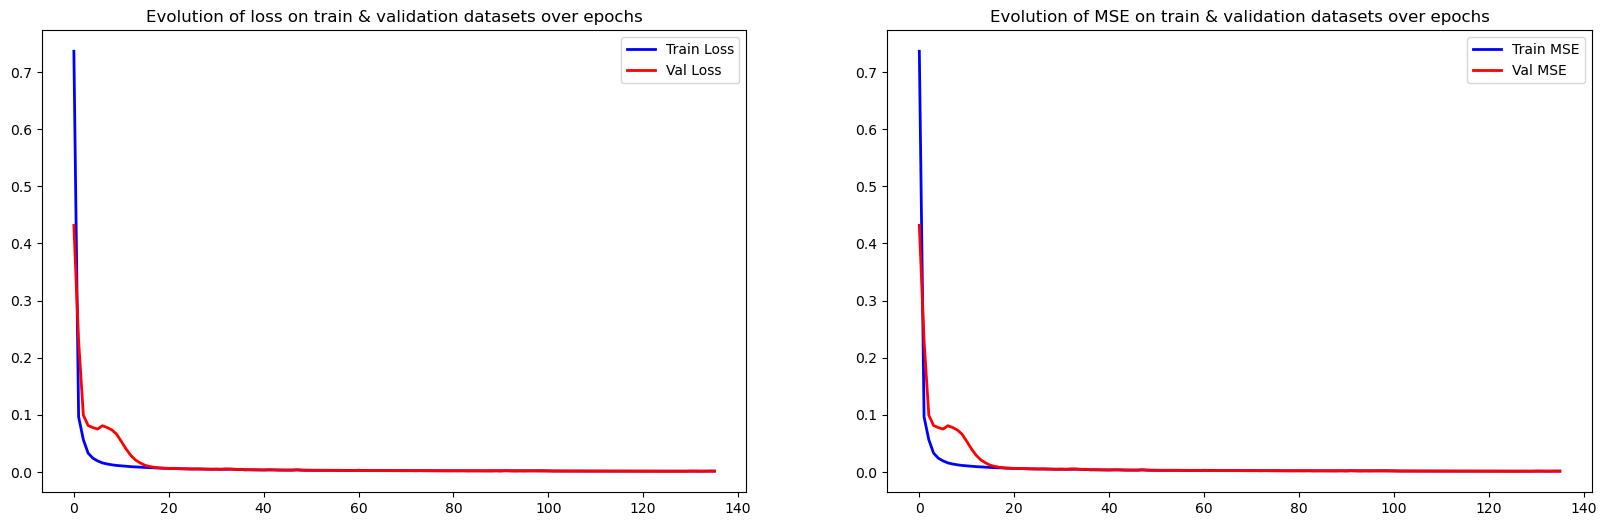

In [13]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mse']
epoch_val_mae = history.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [14]:
y_pred = DNCNN.predict(X_test, batch_size=16)

5/5 [==============================] - 2s 513ms/step


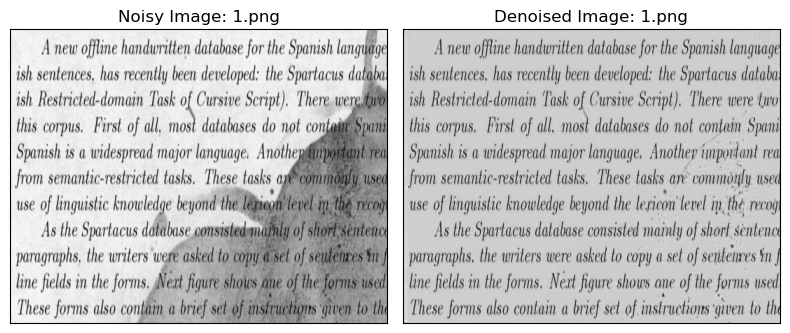

Time taken: 0.40 seconds


In [15]:
import time

# Start the timer
start_time = time.time()

# Your task code here
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(X_test[0][:, :, 0], cmap='gray')
plt.title('Noisy Image: {}'.format(test_img[0]))

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(y_pred[0][:, :, 0], cmap='gray')
plt.title('Denoised Image: {}'.format(test_img[0]))

plt.tight_layout()
plt.show()

# Calculate the elapsed time
elapsed_time = time.time() - start_time
print("Time taken: {:.2f} seconds".format(elapsed_time))
